# Ice algae timing in different regions

## Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.ticker import LogLocator

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import palettable.cmocean.sequential as cmOcSeq
import palettable.cmocean.diverging as cmOcDiv
import seaborn as sns

import textwrap as tw
from datetime import datetime, timedelta

from glob import glob 

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
lreg= lambda y,x : sm.OLS(y, sm.add_constant(x)).fit()
from xhistogram.xarray import histogram as xhist
from scipy.optimize import fsolve

import utilsRegions as urgn
import utilsGen as utl
import mapPlots as mplt
import diagnostics as dgnst
import utlshistograms as uhist

%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8188',n_workers=16, threads_per_worker=1)
# cluster = LocalCluster(dashboard_address=':8181',n_workers=8, threads_per_worker=1)
client = Client(cluster)

http://127.0.0.1:8188/status

In [83]:
cluster.close()
client.close()

#### Load data 

In [3]:
scenarios = ['historical-DFS-G510.00','RCP85-G510.14-G515.00-01']
hist,rcp85 = scenarios
periods = ['1981-2000','2023-2042','2066-2085']
past,pres,futur=periods
runs={past:hist, pres:rcp85, futur:rcp85}
timeperiod = {past: slice('1981','2000'), pres:slice('2023','2042'), futur: slice('2066','2085') }

dadic={}
utl.loadNAAmesh(dadic)

In [4]:
# for scn in scenarios: 
#     utl.openNCfile(dadic,scn,'biolog')
#     utl.openNCfile(dadic,scn,'diad')

#### Regions

In [17]:
dmaskNAA = xr.open_dataset('/tsanta/ahaddon/NAA/mesh/RegionalMasksNAA.nc')
dmesh = xr.open_dataset('/tsanta/ahaddon/NAA/mesh/mesh_mask_naa1_rn_hmin7.nc')
landMask = dmesh.tmask.isel(t=0, z= 0)

In [18]:
regions, rgnMsk, rgnArea = urgn.loadRegions()
cList = plt.colormaps['tab20b'](np.arange(14)/13)
clrs={r:c for r,c in zip(regions,cList)}

extent={}
CAA = 'Canadian Arctic Archipelago'
extent[CAA]=[-124,-77, 67,85]
# SES ='S. East Siberian Sea'
# extent[SES]=[88,165, 68,90]
# CHU = 'S. Chuckchi Sea'
# extent[CHU]=[150,210,60,90]

BEAU = 'Beaufort Sea'
regions.append(BEAU)
rgnMsk[BEAU]= ( rgnMsk['N. Beaufort Sea'] | rgnMsk['S. Beaufort Sea'] )
rgnArea[BEAU] = dadic['didj'].where(rgnMsk[BEAU]).sum(dim=['y','x']).compute()
extent[BEAU] = [-120,-175,65,85]

LAP='Laptev Sea'
regions.append(LAP)
rgnMsk[LAP]= rgnMsk['S. East Siberian Sea'] & (dadic['mesh'].nav_lon>105) & (dadic['mesh'].nav_lon<140)
rgnArea[LAP] = dadic['didj'].where(rgnMsk[LAP]).sum(dim=['y','x']).compute()
extent[LAP]=[80,180, 70,90] 
def pltBdnryLaptev(fig,ax):
    ax.plot([140]*2,[71.5,79],'k-', transform=ccrs.PlateCarree(), lw=1.5)
    ax.plot([105]*2,[77.6,79.7], 'k-',transform=ccrs.PlateCarree(), lw=1.5)
    mplt.pltRgnBdnry(fig,ax,rgnMsk['S. East Siberian Sea']*(dadic['mesh'].nav_lon>105) *(dadic['mesh'].nav_lon<140), dmaskNAA, landMask, s=0.3,color='k',marker='o')    

SIB='E. Siberia Sea'
regions.append(SIB)
rgnMsk[SIB]= ( (rgnMsk['S. East Siberian Sea'] & (dadic['mesh'].nav_lon>140) )
              | (rgnMsk['S. Chuckchi Sea'] & (dadic['mesh'].nav_lon<180) & (dadic['mesh'].nav_lon>140) )
             )
rgnArea[SIB] = dadic['didj'].where(rgnMsk[SIB]).sum(dim=['y','x']).compute()
extent[SIB]=[130,190, 65,88]
def pltBdnrySiberia(fig,ax,wb=False):
    mplt.pltRgnBdnry(fig,ax,rgnMsk['S. East Siberian Sea']*(dadic['mesh'].nav_lon>140) *(dadic['mesh'].nav_lon<161.4), dmaskNAA, landMask, s=0.3,color='k')
    mplt.pltRgnBdnry(fig,ax,rgnMsk['S. Chuckchi Sea']*(dadic['mesh'].nav_lon>162.6), dmaskNAA, landMask,s=0.3,color='k')
    ax.scatter([161.9,162.5], [79,78.9],  transform=ccrs.PlateCarree(),s=0.3,color='k')
    ax.plot([180]*2,[69,75.2],'k-', transform=ccrs.PlateCarree(), lw=1.5)
    if wb: ax.plot([140]*2,[71.5,79],'k-', transform=ccrs.PlateCarree(), lw=1.5)
extent[SIB+LAP]=[80,190,65,90]    

regs = [CAA,BEAU,SIB,LAP]

(None, None)

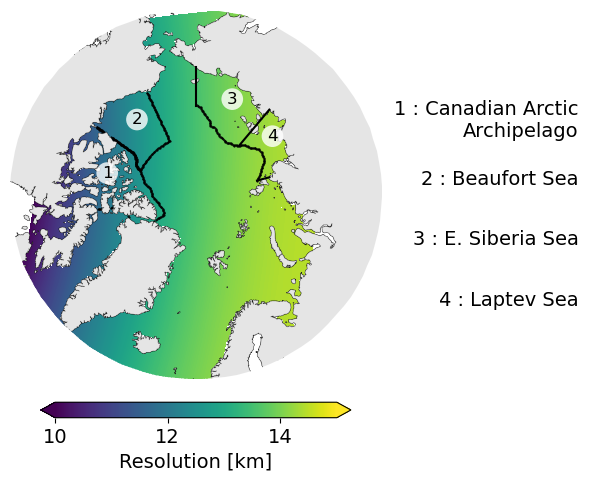

In [19]:
plt.rcParams.update({'font.size': 14})

nregions=len(regs)
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 0], height_ratios=[0.5-(nregions/14),2*(nregions/14),0.6-(nregions/14) ],wspace=.0) 
fig=plt.figure(figsize=(10,6))

ax0=plt.subplot(gs[0:3,0],projection=ccrs.NorthPolarStereo(),frameon=False)
ax0.coastlines(linewidth=0.5,resolution='50m')
ax0.set_extent([-180,180, 60,90] , ccrs.PlateCarree())
mplt.roundBoundary(ax0)
ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor=cfeature.COLORS['land_alt1'],alpha=0.7) )

mplt.singleMap((dadic['didj']/1e6)**(1/2),dadic,fig=fig,ax=ax0,vmin=10,vmax=15,unitName='Resolution [km]')

# region boundaries + number
dmaskNAA['region']=xr.where(dmaskNAA.region==6, 5,dmaskNAA.region) # elimiate boundary between N and S beaufort
for ir,rgn in enumerate(regs[:2]):
    mplt.pltRgnBdnry(fig,ax0,rgnMsk[rgn], dmaskNAA, landMask, s=0.3,color='k',marker='o')
pltBdnryLaptev(fig,ax0)
pltBdnrySiberia(fig,ax0)

# region number
for ir,rgn in enumerate(regs):
    lon,lat = dmaskNAA.nav_lon.where(rgnMsk[rgn]).load().median(),dmaskNAA.nav_lat.where(rgnMsk[rgn]).load().median()
    ax0.text(lon,lat,str(ir+1), transform=ccrs.PlateCarree(),fontsize=12,
                  bbox={'fc':'w','lw':0,'alpha':0.8, 'pad': 0.2,'boxstyle':'circle'})

ax1=plt.subplot(gs[1,1])
ax1.spines[["left", "top", "right",'bottom']].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks(range(2*nregions), [f'{int(i/2)+1} : {tw.fill(regs[int(i/2)],16)}' if i%2==0 else '' for i in range(2*nregions)])#, wrap=True)
ax1.invert_yaxis(), ax1.tick_params(axis='y', length=0) 


## Climatologies

#### Load

In [7]:
processDataDir = '/tsanta/ahaddon/NAA/processedData/'
# processDataDir = '/home/ahaddon/Work/NAA/processedData/'
varsave = ['ileadfra2','icedia','fstric','iceno3','icenh4','icedia','limN','limpar','iceGPPgca']#,'iicethic','isnowthi'
clim={}
for per in periods: 
    scn=runs[per] 
    for var in varsave:
        clim[per+var] = xr.open_dataarray(f'{processDataDir}{scn}/panArctic/{var}_20yclim{per}_1d.nc')

In [8]:
for per in periods: 
    clim[per+'meanIA'] = clim[per+'icedia'].sel(dayofyear=slice(60,181)).mean(dim='dayofyear')
    clim[per+'peakIAfall'] = clim[per+'icedia'].sel(dayofyear=slice(250,365)).max(dim='dayofyear')
    clim[per+'peakIA'] = clim[per+'icedia'].sel(dayofyear=slice(1,249)).max(dim='dayofyear')
diffIAmean=clim[futur+'meanIA'] - clim[past+'meanIA']
diffIApeak=clim[futur+'peakIA'] - clim[past+'peakIA']

In [9]:
climdiag={}
for per in periods:
    scn=runs[per] 
    climdiag[per] = xr.open_dataset(f'{processDataDir}{scn}/panArctic/IAdiagnostics_20yclim{per}.nc').compute()
climdiag[periods[0]]

<xarray.Dataset>
Dimensions:                 (y: 400, x: 568)
Coordinates:
    nav_lat                 (y, x) float32 53.41 53.48 53.56 ... 44.23 44.11
    nav_lon                 (y, x) float32 -132.6 -132.5 -132.4 ... 15.75 15.66
Dimensions without coordinates: y, x
Data variables: (12/22)
    doyNlim5                (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlim15             (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlim5              (y, x) float64 nan nan nan nan ... nan nan nan nan
    doySIbreak              (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlimGTnlim         (y, x) float64 nan nan nan nan ... nan nan nan nan
    least_lim               (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                      ...
    least_lim_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    nonLimGwth_nyears       (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    lengthPAR_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doyIApeak_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doySIfreezeUp_nyears    (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doyIAstd_nyears         (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

#### Regional mean ice algae

In [10]:
for per in periods:
    for rgn in regs:
        ia =clim[per+'icedia'].where(rgnMsk[rgn])
        si =clim[per+'ileadfra2'].where(rgnMsk[rgn])
        clim[per+rgn+'regMeanIA']= ((ia*si).sum(dim=['x','y']) / si.sum(dim=['x','y'])).compute()

/home/ahaddon/miniconda3/envs/xr/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/ahaddon/miniconda3/envs/xr/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


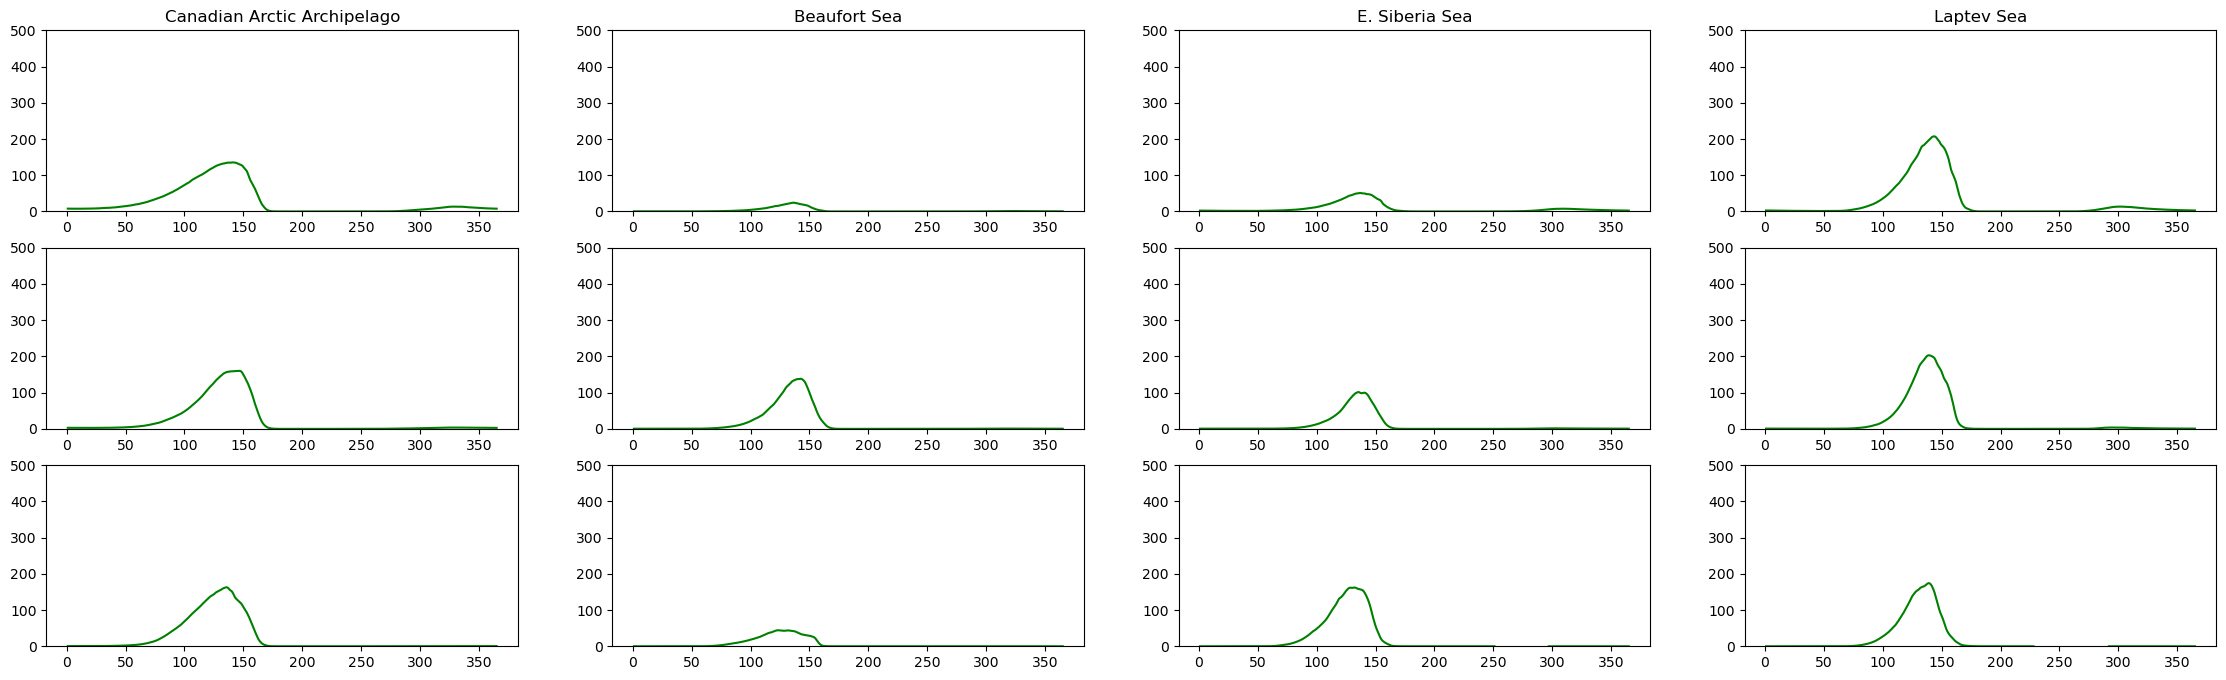

In [11]:
fig,ax= plt.subplots(3,4,figsize=(28,8))

for ir,rgn in enumerate(regs):
    ax[0,ir].set_title(rgn)
    for ip, per in enumerate(periods):
        ax[ip,ir].plot(clim[per+rgn+'regMeanIA'].dayofyear, clim[per+rgn+'regMeanIA']*12, 'g')
        ax[ip,ir].set_ylim(0,500)
        

## Maps

In [27]:
def keydates(rgn, figsize=(8,8),central_longitude=0,labelpos=(0.1,0.9)):
    fig,ax = mplt.initmaps(3,4,figsize=figsize,extent=extent[rgn], central_longitude=central_longitude)
    fig.tight_layout()

    ax[0,0].set_title('Phototrophy Onset', fontsize=12)
    ax[0,1].set_title('Half PAR Limitation', fontsize=12)
    ax[0,2].set_title('Half N Limitation', fontsize=12)
    ax[0,3].set_title('Sea Ice Break up', fontsize=12)

    for i,per in enumerate(periods):
        ax[i,0].text(-0.1,0.5, per, rotation='vertical', transform=ax[i,0].transAxes, fontsize=12, verticalalignment='center')

        f,a,pl=mplt.singleMap(climdiag[per]['doyPARlim15'], dadic, fig=fig,ax=ax[i,0], cbar=False, 
                              vmin=30,vmax=210, cmap = sns.color_palette("mako_r", as_cmap=True),
                              hatchMsk=climdiag[per].doyPARlim15_nyears<10, hatchlw=0.2, 
                             )

        f,a,pl=mplt.singleMap(climdiag[per]['doyPARlim5'], dadic, fig=fig,ax=ax[i,1], cbar=False, 
                              vmin=30,vmax=210, cmap = sns.color_palette("mako_r", as_cmap=True),
                              hatchMsk=climdiag[per].doyPARlim5_nyears<10, hatchlw=0.2, 
                             )

        f,a,pl=mplt.singleMap(climdiag[per]['doyNlim5'], dadic, fig=fig,ax=ax[i,2], cbar=False, 
                              vmin=30,vmax=210, cmap =sns.color_palette("mako_r", as_cmap=True),
                              hatchMsk=climdiag[per].doyNlim5_nyears<10, hatchlw=0.2,
                             )

        f,a,pl=mplt.singleMap(climdiag[per]['doySIbreak'], dadic, fig=fig,ax=ax[i,3], cbar=False, 
                              vmin=30,vmax=210,  cmap =sns.color_palette("mako_r", as_cmap=True),
                              hatchMsk=climdiag[per].doySIbreak_nyears<10, hatchlw=0.2, hatchColor='w',
                             )

    ltr=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    for il,a in enumerate(fig.axes): a.text(*labelpos,f'({ltr[il]})',transform=a.transAxes, fontsize=12)
    
    # plt.subplots_adjust(wspace=0.1,hspace=0.1)
    # cbar_ax = fig.add_axes([1/4-0.14, -0.01, 0.3, 0.01])                               
    cbar_ax = fig.add_axes([1, 1/2-0.15, 0.02, 0.3])                               
    cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='vertical', shrink=0.4)
    cl.set_label('day of year')
    cbar_ax.set_yticks(range(30,211,30))

    # leg = cbar_ax.legend(loc='center',bbox_to_anchor=(2.25, -1), handlelength=4, frameon=False,
    # handles=[mpatches.Patch(facecolor='w',hatch=r'xxx',label='Diagnostic defined \nfor less than 10 years')])
    # leg.get_patches()[0].set_height(22)
    # leg.get_patches()[0].set_y(-7)
    
    return fig, ax

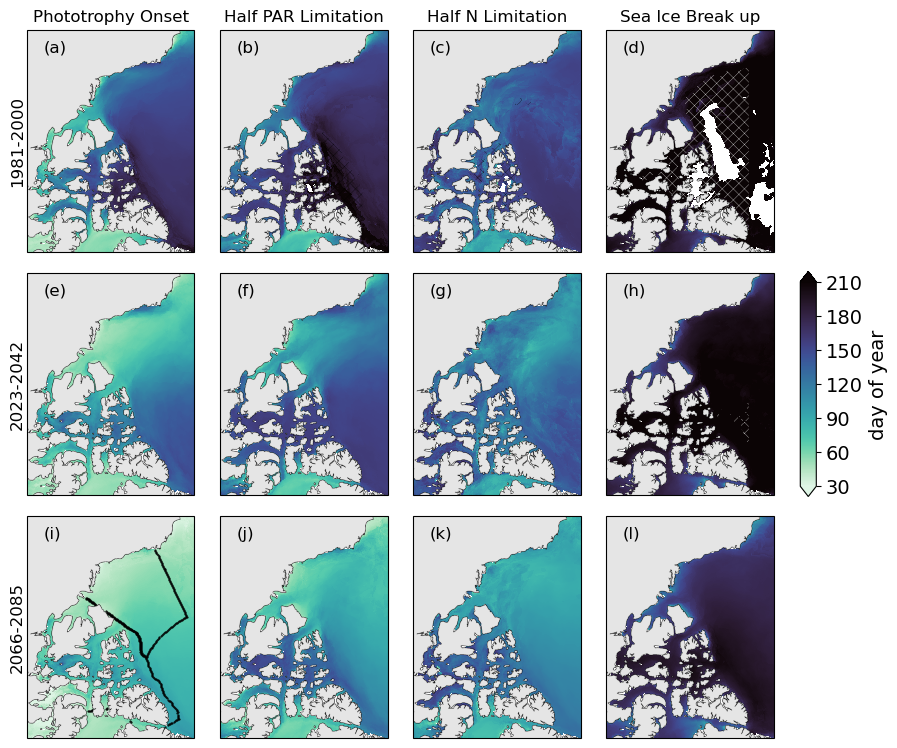

In [28]:
extent[CAA+BEAU]=[-155,-77,67,82]
fig,ax= keydates(CAA+BEAU,figsize=(8,7.5))
for ir,rgn in enumerate([CAA,BEAU]):
    mplt.pltRgnBdnry(fig,ax[-1,0],rgnMsk[rgn], dmaskNAA, landMask, s=0.3,color='k',marker='o')
plt.savefig('../figs/IAphenology23/keydatesMaps-CAA+Beau.png',bbox_inches='tight',dpi=300)
plt.savefig('../figs/IAphenology23/keydatesMaps-CAA+Beau-90dpi.png',bbox_inches='tight',dpi=90)

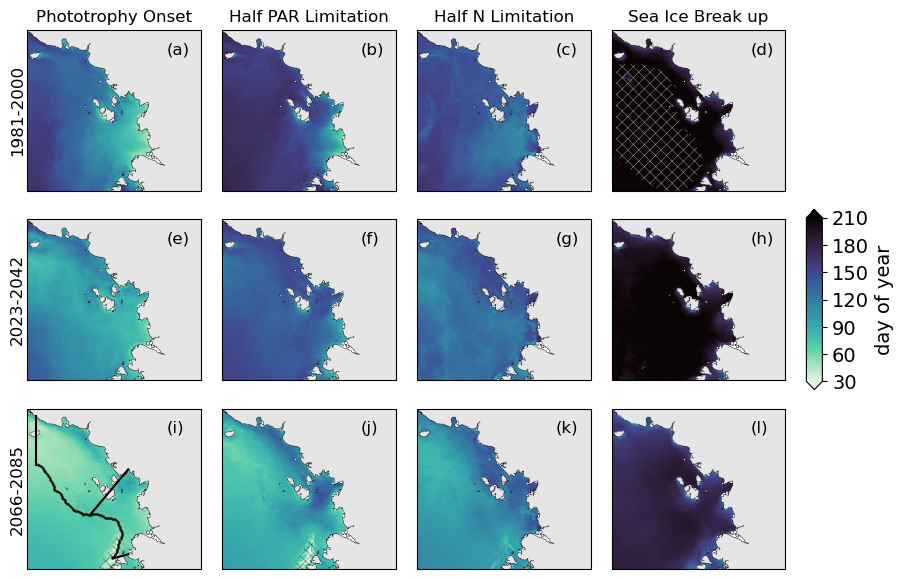

In [29]:
extent[SIB+LAP]=[105,183,68,85]    
fig,ax=keydates(SIB+LAP,figsize=(8,6),labelpos=(0.8,0.85))
pltBdnryLaptev(fig,ax[-1,0])
pltBdnrySiberia(fig,ax[-1,0])
plt.savefig('../figs/IAphenology23/keydatesMaps-SiberaLaptev.png',bbox_inches='tight',dpi=300)
plt.savefig('../figs/IAphenology23/keydatesMaps-SiberaLaptev-90dpi.png',bbox_inches='tight',dpi=90)

## Phenology Histograms

In [30]:
pc,pc15,nc,ic,iac='tab:orange','tab:gray','tab:blue','r','tab:brown'

In [31]:
hist={}

In [32]:
for rgn in regs:
    for per in periods:
        hist[rgn+per+'icedia'] = xhist((clim[per+'icedia']*12).where(rgnMsk[rgn]), bins=[np.linspace(0, 500, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
        # hist[rgn+per+'iicethic'] = xhist(clim[per+'iicethic'].where(rgnMsk[rgn]), bins=[np.linspace(0, 3, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
        # hist[rgn+per+'isnowthi'] = xhist(clim[per+'isnowthi'].where(rgnMsk[rgn]), bins=[np.linspace(0, 0.4, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
        # hist[rgn+per+'fstric'] = xhist(clim[per+'fstric'].where(rgnMsk[rgn]), bins=[np.linspace(0, 3, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])    
        # hist[rgn+per+'limpar'] = xhist(clim[per+'limpar'].where(rgnMsk[rgn]), bins=[np.linspace(0, 1, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])    
        # hist[rgn+per+'iceno3'] = xhist(clim[per+'iceno3'].where(rgnMsk[rgn]), bins=[np.linspace(0, 0.3, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
        # hist[rgn+per+'icenh4'] = xhist(clim[per+'icenh4'].where(rgnMsk[rgn]), bins=[np.linspace(0, 0.3, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
        # hist[rgn+per+'limN'] = xhist(clim[per+'limN'].where(rgnMsk[rgn]), bins=[np.linspace(0, 1, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])    

        hist[rgn+per+'doyPARlim15'] = xhist(climdiag[per]['doyPARlim15'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])  
        hist[rgn+per+'doyPARlim5'] = xhist(climdiag[per]['doyPARlim5'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])    
        hist[rgn+per+'doyNlim5'] = xhist(climdiag[per]['doyNlim5'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])    
        hist[rgn+per+'doyPARlimGTnlim'] = xhist(climdiag[per]['doyPARlimGTnlim'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
        hist[rgn+per+'doySIbreak'] = xhist(climdiag[per]['doySIbreak'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
        hist[rgn+per+'doySIfreezeUp'] = xhist(climdiag[per]['doySIfreezeUp'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
        hist[rgn+per+'doyIApeak'] = xhist(climdiag[per]['doyIApeak'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
        hist[rgn+per+'doyIAstd'] = xhist(climdiag[per]['doyIAstd'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
    
        hist[rgn+per+'lengthPAR'] = xhist(climdiag[per]['lengthPAR'].where(rgnMsk[rgn]), bins=[np.linspace(0, 210, 210+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
        hist[rgn+per+'nonLimGwth'] = xhist(climdiag[per]['nonLimGwth'].where(rgnMsk[rgn]), bins=[np.linspace(-75, 125, 125+75+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
                

In [33]:
rgn='Pan Arctic'
rgnMsk[rgn] = (dadic['mesh'].nav_lat>60) & (dadic['landMask']) 
rgnArea[rgn] = dadic['didj'].where(rgnMsk[rgn]).sum(dim=['y','x']).compute()

In [34]:
for per in periods:
    hist[rgn+per+'icedia'] = xhist((clim[per+'icedia']*12).where(rgnMsk[rgn]), bins=[np.linspace(0, 400, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
    # hist[rgn+per+'iicethic'] = xhist(clim[per+'iicethic'].where(rgnMsk[rgn]), bins=[np.linspace(0, 3, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
    # hist[rgn+per+'isnowthi'] = xhist(clim[per+'isnowthi'].where(rgnMsk[rgn]), bins=[np.linspace(0, 0.4, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
    # hist[rgn+per+'fstric'] = xhist(clim[per+'fstric'].where(rgnMsk[rgn]), bins=[np.linspace(0, 3, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])    
    # hist[rgn+per+'limpar'] = xhist(clim[per+'limpar'].where(rgnMsk[rgn]), bins=[np.linspace(0, 1, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])    
    # hist[rgn+per+'iceno3'] = xhist(clim[per+'iceno3'].where(rgnMsk[rgn]), bins=[np.linspace(0, 0.3, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
    # hist[rgn+per+'icenh4'] = xhist(clim[per+'icenh4'].where(rgnMsk[rgn]), bins=[np.linspace(0, 0.3, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])
    # hist[rgn+per+'limN'] = xhist(clim[per+'limN'].where(rgnMsk[rgn]), bins=[np.linspace(0, 1, 101)], dim=['y','x'], weights=dadic['didj']/rgnArea[rgn])    
    
    hist[rgn+per+'doyPARlim15'] = xhist(climdiag[per]['doyPARlim15'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])  
    hist[rgn+per+'doyPARlim5'] = xhist(climdiag[per]['doyPARlim5'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])    
    hist[rgn+per+'doyNlim5'] = xhist(climdiag[per]['doyNlim5'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])    
    hist[rgn+per+'doyPARlimGTnlim'] = xhist(climdiag[per]['doyPARlimGTnlim'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
    hist[rgn+per+'doySIbreak'] = xhist(climdiag[per]['doySIbreak'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
    hist[rgn+per+'doySIfreezeUp'] = xhist(climdiag[per]['doySIfreezeUp'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
    hist[rgn+per+'doyIApeak'] = xhist(climdiag[per]['doyIApeak'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
    hist[rgn+per+'doyIAstd'] = xhist(climdiag[per]['doyIAstd'].where(rgnMsk[rgn]), bins=[np.linspace(0, 365, 365+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])

    hist[rgn+per+'lengthPAR'] = xhist(climdiag[per]['lengthPAR'].where(rgnMsk[rgn]), bins=[np.linspace(0, 210, 210+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])
    hist[rgn+per+'nonLimGwth'] = xhist(climdiag[per]['nonLimGwth'].where(rgnMsk[rgn]), bins=[np.linspace(-75, 125, 125+75+1)], dim=['y','x'],weights=dadic['didj']/rgnArea[rgn])

### Days of limitation

In [35]:
days=[datetime(2001, 1, 1) + timedelta(d) for d in range(365)]
middledayofmonth = [datetime(2001, 1, 15) + timedelta(hours=730*m) for m in range(12)]
fstdayofmonth = [d.replace(day=1) for d in middledayofmonth]

def monthTicks(ax,grid=False,start_sept=False):
    if start_sept:
        ax.set_xticks(fstdayofmonth_sept, [] )
        ax.set_xticks(middledayofmonth_sept, [d.strftime(format='%b')[0] for d in middledayofmonth_sept ],minor=True )
    else:
        ax.set_xticks(fstdayofmonth, [] )
        ax.set_xticks(middledayofmonth, [d.strftime(format='%b')[0] for d in middledayofmonth ],minor=True )
    ax.tick_params(axis='x', which='minor', length=0)
    if grid: ax.grid(axis='x',ls=':')

def pltdayHist(dayhist, varDay, color, varsDayName,fig,ax,fill=False, pad=0):
    ax.plot(days, pad+dayhist.where(dayhist>0), c=color)
    i_meanday=int(varDay.load().median()-1)
    ax.plot([days[i_meanday]]*2,[pad,pad+dayhist[i_meanday]],'--',color=color, label = days[i_meanday].strftime(format='%-d %b') )
    if fill:
        ax.fill_between(days, pad, pad+dayhist.where(dayhist>0), color=color, alpha=0.5)

In [36]:
def keydateshist(rgn, fig=None, ax=None, freqMax=0.1):
    if fig is None: 
        fig,ax=plt.subplots(3,1,figsize=(8,7))
        fig.suptitle(rgn)
    
    for ip, per in enumerate(periods):
        ax[ip].set_title(per)
        monthTicks(ax[ip],grid=True)
        ax[ip].set_xlim(days[0],days[-1])
        ax[ip].set_ylim(0,freqMax) 
        pltdayHist(hist[rgn+per+'doyPARlim15'], climdiag[per]['doyPARlim15'].where(rgnMsk[rgn]), pc15, '$L_{PAR}$ = 0.16', fig,ax[ip])
        pltdayHist(hist[rgn+per+'doyPARlim5'], climdiag[per]['doyPARlim5'].where(rgnMsk[rgn]), pc, '$L_{PAR}$ = 0.5', fig,ax[ip])
        pltdayHist(hist[rgn+per+'doyNlim5'], climdiag[per]['doyNlim5'].where(rgnMsk[rgn]), nc, '$L_{N}$ = 0.5', fig,ax[ip])
        # uhist.pltdayHist(hist[rgn+per+'doyPARlimGTnlim'], climdiag[per]['doyPARlimGTnlim'].where(rgnMsk[rgn]), swc,'Limitation switch', fig,ax[ip])
        pltdayHist(hist[rgn+per+'doyIApeak'], climdiag[per]['doyIApeak'].where(rgnMsk[rgn]), iac,'IA spring max', fig,ax[ip])
        pltdayHist(hist[rgn+per+'doySIbreak'], climdiag[per]['doySIbreak'].where(rgnMsk[rgn]), ic, 'SI break up', fig,ax[ip])
        ax[ip].legend(fontsize=10,loc='upper right',title="Median dates")

    # plt.tight_layout()
    return fig,ax

In [37]:
def keydateshist_stacked(rgn, fig=None, ax=None, freqMax=0.1,yticks=[0,0.01,0.02], perlbl=True):
    if fig is None: 
        fig,ax=plt.subplots(3,1,figsize=(5,7))
        fig.suptitle(rgn)
    
    for ip, per in enumerate(periods):
        # ax[ip].set_title(per,fontsize=12)
        if perlbl: ax[ip].text(-0.05,0.5, per, rotation='vertical', transform=ax[ip].transAxes, fontsize=12, verticalalignment='center')

        monthTicks(ax[ip],grid=True)
            
        ax[ip].set_xlim(days[0],days[-1])
        ax[ip].set_ylim(0,3.25*freqMax) 
        # ax[ip].set_yticks([0,freqMax/4,freqMax/2],[0,freqMax/4,freqMax/2],fontsize=8) 
        if not perlbl: ax[ip].set_yticks(yticks,yticks,fontsize=7) 
        else: ax[ip].yaxis.tick_right(); ax[ip].set_yticks(yticks,[]) 
        # ax[ip].set_yticks(yticks,yticks,fontsize=7) 
        # ax[ip].yaxis.tick_right();

        pltdayHist(hist[rgn+per+'doyPARlim15'], climdiag[per]['doyPARlim15'].where(rgnMsk[rgn]), pc15, '$L_{PAR}$ = 0.16', fig,ax[ip], fill=True, pad=2.25*freqMax)
        pltdayHist(hist[rgn+per+'doyPARlim5'], climdiag[per]['doyPARlim5'].where(rgnMsk[rgn]), pc, '$L_{PAR}$ = 0.5', fig,ax[ip], fill=True, pad=1.5*freqMax)
        pltdayHist(hist[rgn+per+'doyNlim5'], climdiag[per]['doyNlim5'].where(rgnMsk[rgn]), nc, '$L_{N}$ = 0.5', fig,ax[ip], fill=True, pad=0.75*freqMax)
        # pltdayHist(hist[rgn+per+'doyIApeak'], climdiag[per]['doyIApeak'].where(rgnMsk[rgn]), iac,'IA spring max', fig,ax[ip], fill=True, pad=0.75*freqMax)
        pltdayHist(hist[rgn+per+'doySIbreak'], climdiag[per]['doySIbreak'].where(rgnMsk[rgn]), ic, 'SI break up', fig,ax[ip], fill=True, pad=0)
       
        ax[ip].legend(fontsize=10,loc='upper right',title="Median dates")
    # plt.tight_layout()
    return fig,ax

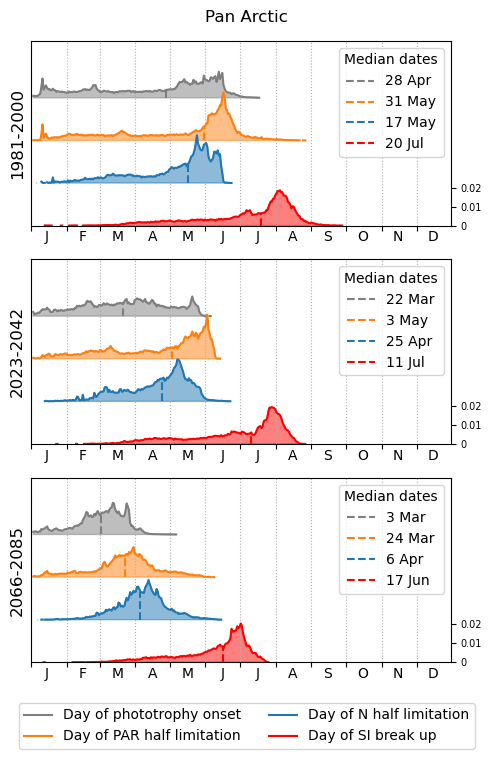

In [21]:
plt.rcParams.update({'font.size': 10})
fig,ax=keydateshist_stacked('Pan Arctic', freqMax=0.03)
plt.tight_layout()
ax= fig.add_axes([1/2-0.15, -0.01, 0.3, 0.01])      
ax.set_axis_off()
ax.legend(loc='upper center', ncol=2, handles=[
    Line2D([], [], color=pc15, label='Day of phototrophy onset'),
    Line2D([], [], color=pc, label='Day of PAR half limitation'), 
    Line2D([], [], color=nc, label='Day of N half limitation'), 
    # Line2D([], [], color=iac, label='Day of IA spring max'), 
    Line2D([], [], color=ic, label='Day of SI break up')
                    ])   

plt.savefig('figs/IAphenology23/key-dates-panArctic.png',bbox_inches='tight',dpi=300)


In [48]:
def plt2rgnsKeyDatesHist(regns,labelpos=(0.01,0.87)):
    plt.rcParams.update({'font.size': 10})

    gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1],height_ratios=[1,1,1,0.25],wspace=0.12, hspace=0.2) 
    fig=plt.figure(figsize=(11,6))
    plt.tight_layout()
    # plt.suptitle('Histograms of key dates',fontsize=14)

    for ir,rgn in enumerate(regns):
        # ax=plt.subplot(gs[int(ir/2)*4, (ir%2)])
        # ax.text(0.5,-2, rgn, horizontalalignment='center', fontsize=12)
        # ax.set_axis_off()

        ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*4,int(ir/2)*4+3)]
        ax[0].set_title(rgn)
        keydateshist_stacked(rgn, fig, ax=ax, freqMax=0.05,yticks=[0,0.015,0.03], perlbl=ir-1)

    ltr=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    for il,a in enumerate(fig.axes): a.text(*labelpos,f'({ltr[il+12]})',transform=a.transAxes, fontsize=12)

    ax= plt.subplot(gs[-1,:])
    ax.set_axis_off()
    ax.legend(loc='upper center', ncol=2, fontsize=10, handles=[
        Line2D([], [], color=pc15, label='Day of phototrophy onset'),
        Line2D([], [], color=pc, label='Day of PAR half limitation'), 
        Line2D([], [], color=nc, label='Day of N half limitation'), 
        Line2D([], [], color=ic, label='Day of SI break up')
                        ])   

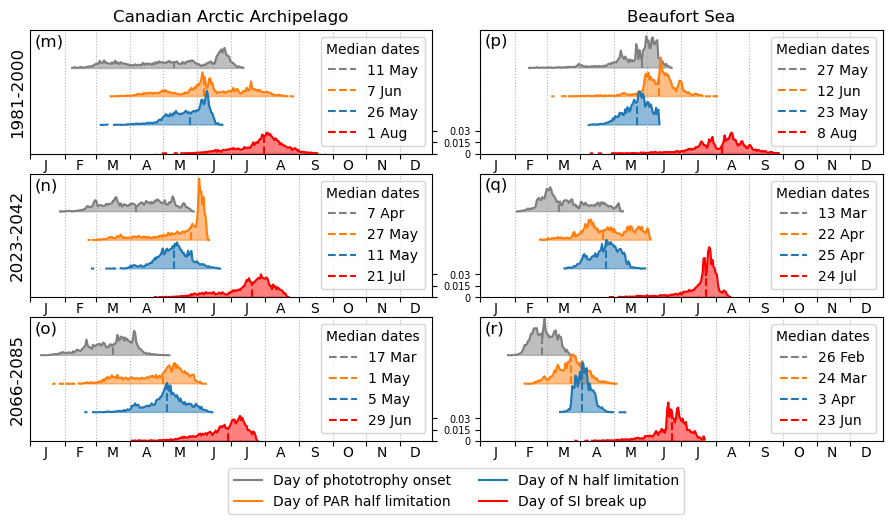

In [49]:
plt2rgnsKeyDatesHist([CAA,BEAU])
plt.savefig('../figs/IAphenology23/keydatesHistog-CAA+Beauf.png',bbox_inches='tight',dpi=300)

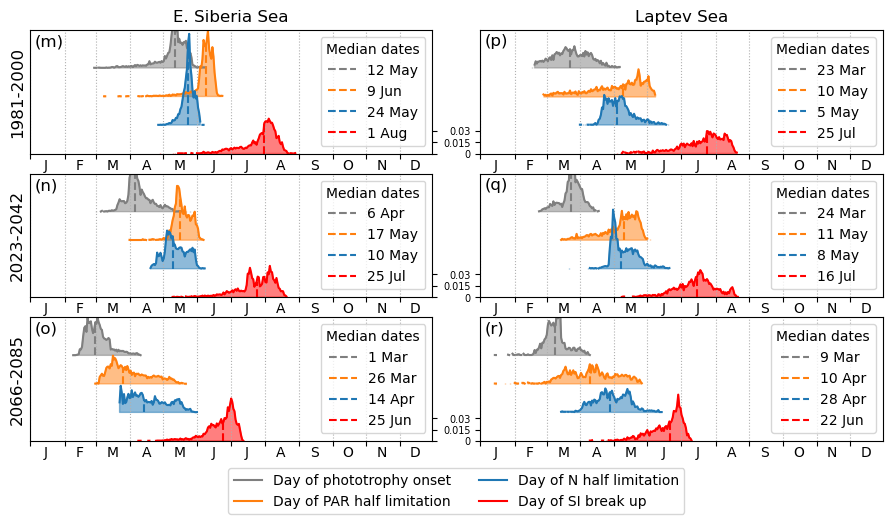

In [50]:
plt2rgnsKeyDatesHist([SIB,LAP])
plt.savefig('../figs/IAphenology23/keydatesHistog-SiberaLaptev.png',bbox_inches='tight',dpi=300)

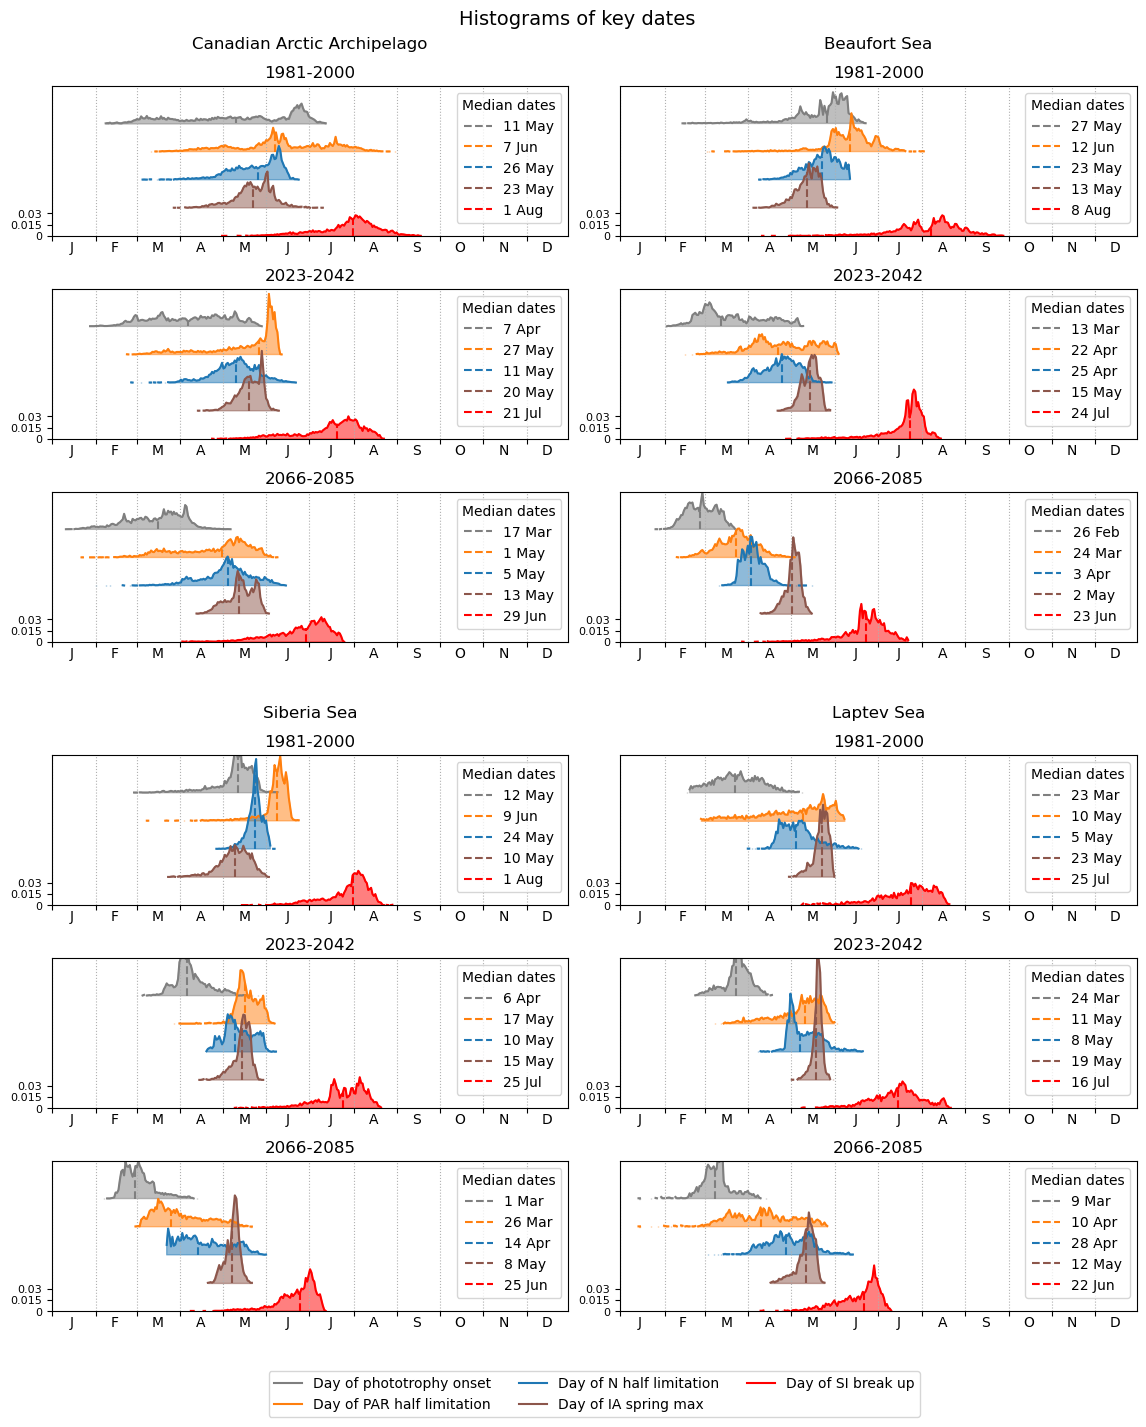

In [266]:
plt.rcParams.update({'font.size': 10})

gs = gridspec.GridSpec(9, 2, width_ratios=[1, 1],height_ratios=[0.05,1,1,1,0.05,1,1,1,0.25],wspace=0.1, hspace=0.5, top=0.97) 
fig=plt.figure(figsize=(14,16))
plt.suptitle('Histograms of key dates',fontsize=14)

for ir,rgn in enumerate(regs):
    ax=plt.subplot(gs[int(ir/2)*4, (ir%2)])
    ax.text(0.5,-2, rgn, horizontalalignment='center', fontsize=12)
    ax.set_axis_off()
    
    ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*4+1,int(ir/2)*4+4)]
    keydateshist_stacked(rgn, fig, ax=ax, freqMax=0.05,yticks=[0,0.015,0.03])

ax= plt.subplot(gs[-1,:])
ax.set_axis_off()
ax.legend(loc='upper center', ncol=3, handles=[
    Line2D([], [], color=pc15, label='Day of phototrophy onset'),
    Line2D([], [], color=pc, label='Day of PAR half limitation'), 
    Line2D([], [], color=nc, label='Day of N half limitation'), 
    Line2D([], [], color=iac, label='Day of IA spring max'), 
    Line2D([], [], color=ic, label='Day of SI break up')
                    ])   


### Growth periods

In [19]:
phc, hgc='tab:gray','tab:green'

In [77]:
def periodshist(rgn, fig=None, ax=None, freqMax=0.1):
    if fig is None: 
        fig,ax=plt.subplots(3,1,figsize=(8,7))
        fig.suptitle(rgn)

    for ip, per in enumerate(periods):
        ax[ip].set_title(per)
        uhist.pltperiodHist(hist[rgn+per+'lengthPAR'], climdiag[per]['lengthPAR'].where(rgnMsk[rgn]), phc, fig=fig,ax=ax[ip], freqMax=freqMax)
        uhist.pltperiodHist(hist[rgn+per+'nonLimGwth'], climdiag[per]['nonLimGwth'].where(rgnMsk[rgn]), hgc, fig=fig,ax=ax[ip], freqMax=freqMax)

    # plt.tight_layout()
    return fig,ax

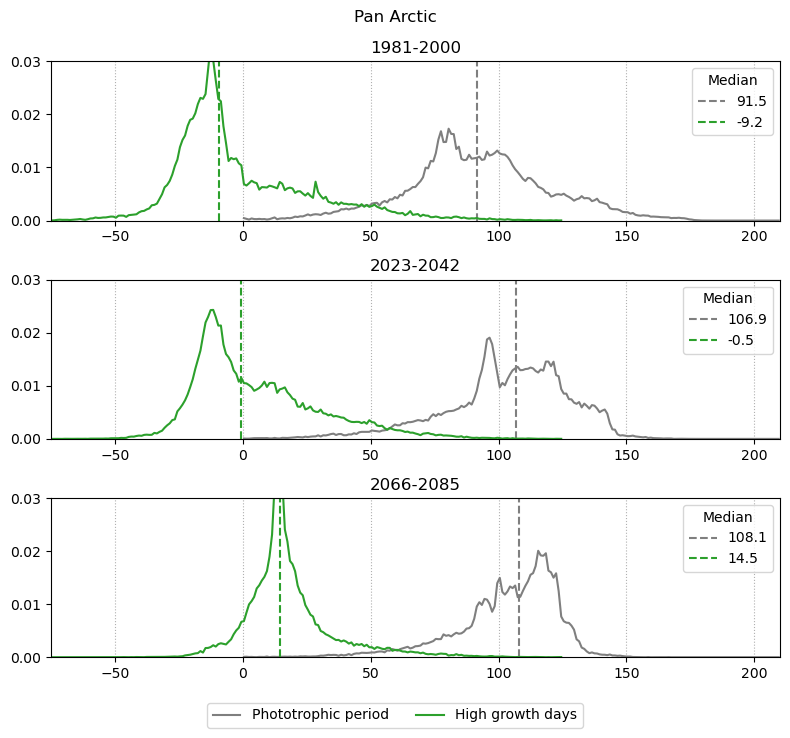

In [79]:
plt.rcParams.update({'font.size': 10})
fig,ax=periodshist('Pan Arctic', freqMax=0.03)
plt.tight_layout()
ax= fig.add_axes([1/2-0.15, -0.01, 0.3, 0.01])      
ax.set_axis_off()
ax.legend(loc='upper center', ncol=2, handles=[
    Line2D([], [], color=phc, label='Phototrophic period'),
    Line2D([], [], color=hgc, label='High growth days'), 
                    ])   


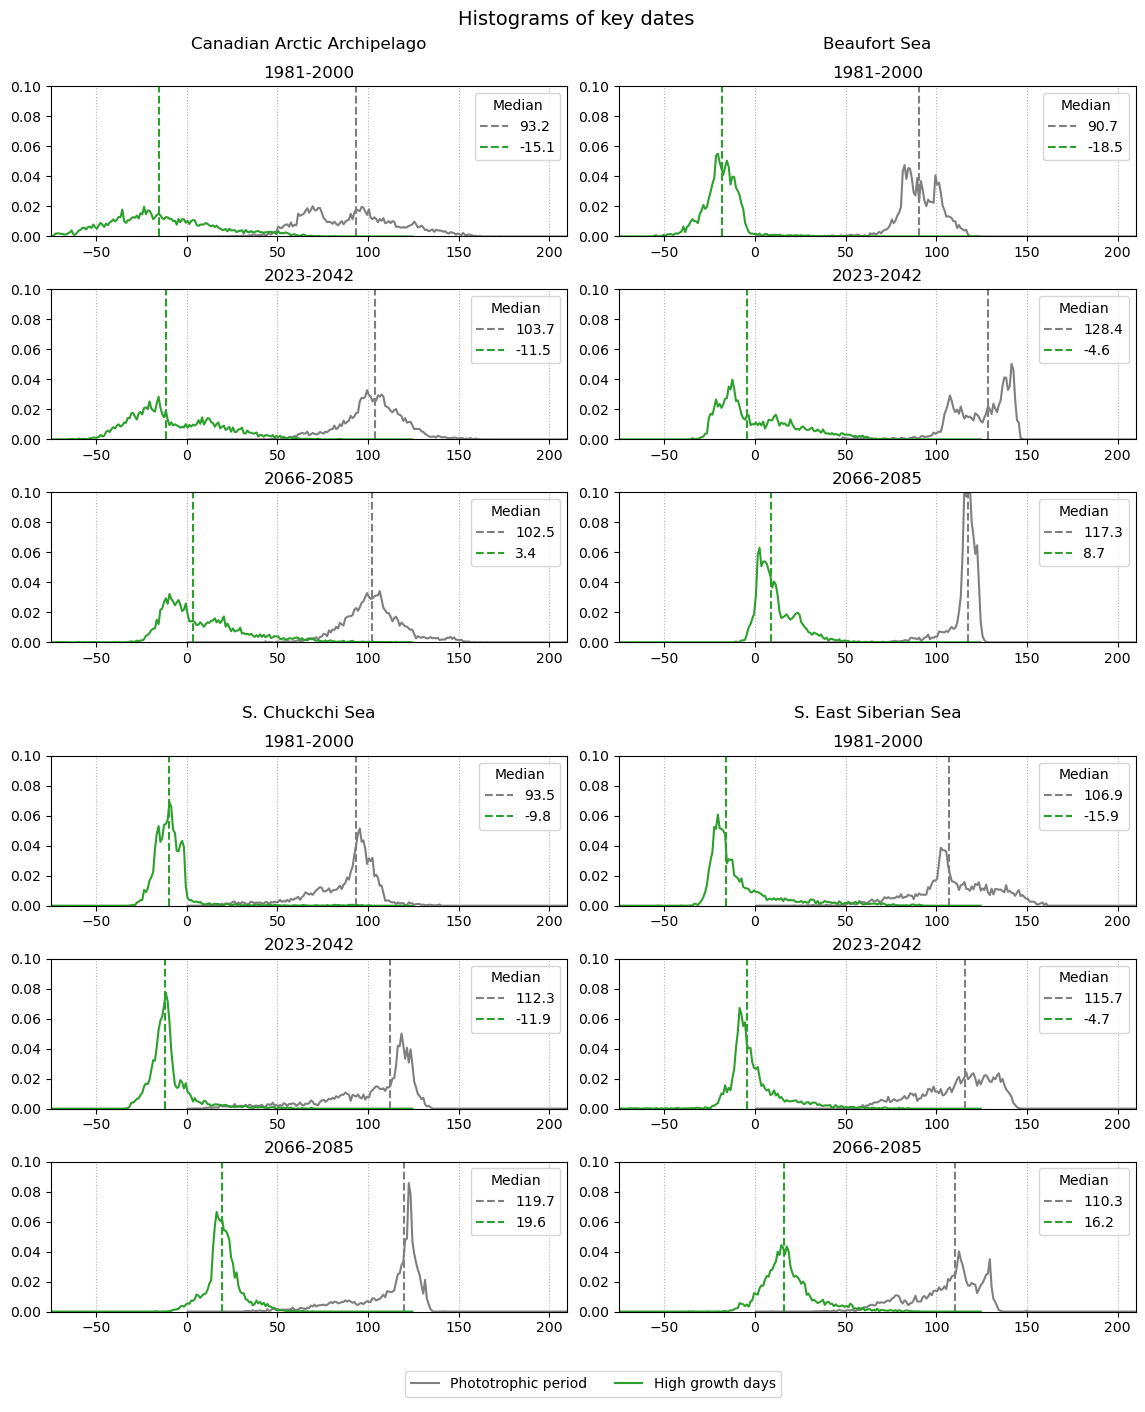

In [80]:
plt.rcParams.update({'font.size': 10})

gs = gridspec.GridSpec(9, 2, width_ratios=[1, 1],height_ratios=[0.05,1,1,1,0.05,1,1,1,0.25],wspace=0.1, hspace=0.5, top=0.97) 
fig=plt.figure(figsize=(14,16))
plt.suptitle('Histograms of key dates',fontsize=14)

for ir,rgn in enumerate(regs):
    ax=plt.subplot(gs[int(ir/2)*4, (ir%2)])
    ax.text(0.5,-2, rgn, horizontalalignment='center', fontsize=12)
    ax.set_axis_off()
    
    ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*4+1,int(ir/2)*4+4)]
    periodshist(rgn, fig, ax=ax )

ax= plt.subplot(gs[-1,:])
ax.set_axis_off()
ax.legend(loc='upper center', ncol=2, handles=[
    Line2D([], [], color=phc, label='Phototrophic period'),
    Line2D([], [], color=hgc, label='High growth days'), 
                    ])   


### IA dates

In [56]:
stdc,mxc = 'tab:purple', 'tab:brown'

In [57]:
def IAdateshist_stacked(rgn, fig=None, ax=None, freqMax=0.1,yticks=[0,0.01,0.02], perlbl=True):
    if fig is None: 
        fig,ax=plt.subplots(3,1,figsize=(5,5))
        fig.suptitle(rgn)
    
    for ip, per in enumerate(periods):
        # ax[ip].set_title(per,fontsize=12)
        if perlbl: ax[ip].text(-0.05,0.5, per, rotation='vertical', transform=ax[ip].transAxes, fontsize=12, verticalalignment='center')

        monthTicks(ax[ip],grid=True)
            
        ax[ip].set_xlim(days[0],days[-1])
        ax[ip].set_ylim(0,1.75*freqMax) 
        # ax[ip].set_yticks([0,freqMax/4,freqMax/2],[0,freqMax/4,freqMax/2],fontsize=8) 
        # if not perlbl: ax[ip].set_yticks(yticks,yticks,fontsize=7) 
        # else: ax[ip].yaxis.tick_right(); ax[ip].set_yticks(yticks,[]) 
        ax[ip].set_yticks(yticks,yticks,fontsize=7); ax[ip].yaxis.tick_right()

        pltdayHist(hist[rgn+per+'doyIAstd'], climdiag[per]['doyIAstd'].where(rgnMsk[rgn]), stdc,'IA STD', fig,ax[ip], fill=True, pad=0.75*freqMax)
        pltdayHist(hist[rgn+per+'doyIApeak'], climdiag[per]['doyIApeak'].where(rgnMsk[rgn]), mxc,'IA spring max', fig,ax[ip], fill=True, pad=0)
       
        ax[ip].legend(fontsize=10,loc='upper right',title="Median dates")
    # plt.tight_layout()
    return fig,ax

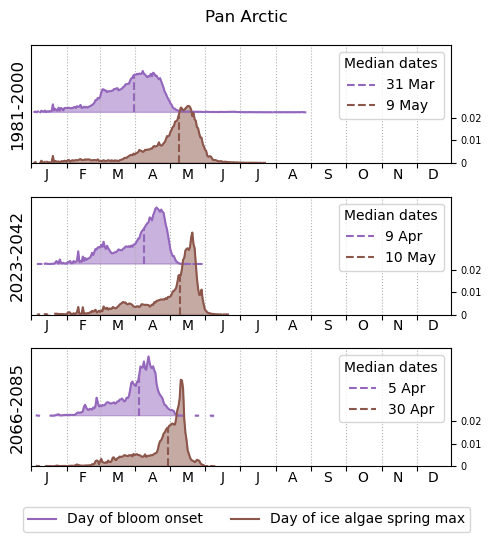

In [48]:
plt.rcParams.update({'font.size': 10})
fig,ax=IAdateshist_stacked('Pan Arctic', freqMax=0.03)
plt.tight_layout()
ax= fig.add_axes([1/2-0.15, -0.01, 0.3, 0.01])      
ax.set_axis_off()
ax.legend(loc='upper center', ncol=2, handles=[
    Line2D([], [], color=stdc, label='Day of bloom onset'),
    Line2D([], [], color=mxc, label='Day of ice algae spring max'), 
                    ])   
plt.savefig('figs/IAphenology23/bloomDates-panArctic.png',bbox_inches='tight',dpi=300)

### Ice Algae

In [53]:
def IAhist(rgn, fig=None, ax=None, vmin=0,vmax=0.02,leftSpines=True, logscale=False):
    if fig is None: 
        fig,ax=plt.subplots(3,1,figsize=(8,7))
        fig.suptitle(rgn)

    for ip, per in enumerate(periods):
        # ax[ip].set_title(per)
        uhist.pltHistDly(hist[rgn+per+'icedia'], cmap='Greens', unit='mg C m$^{-2}$',
                        vmin=vmin,vmax=vmax, fig=fig,ax=ax[ip], cbar=False, leftSpines=leftSpines, logscale=logscale)

    # plt.tight_layout()
    return fig,ax

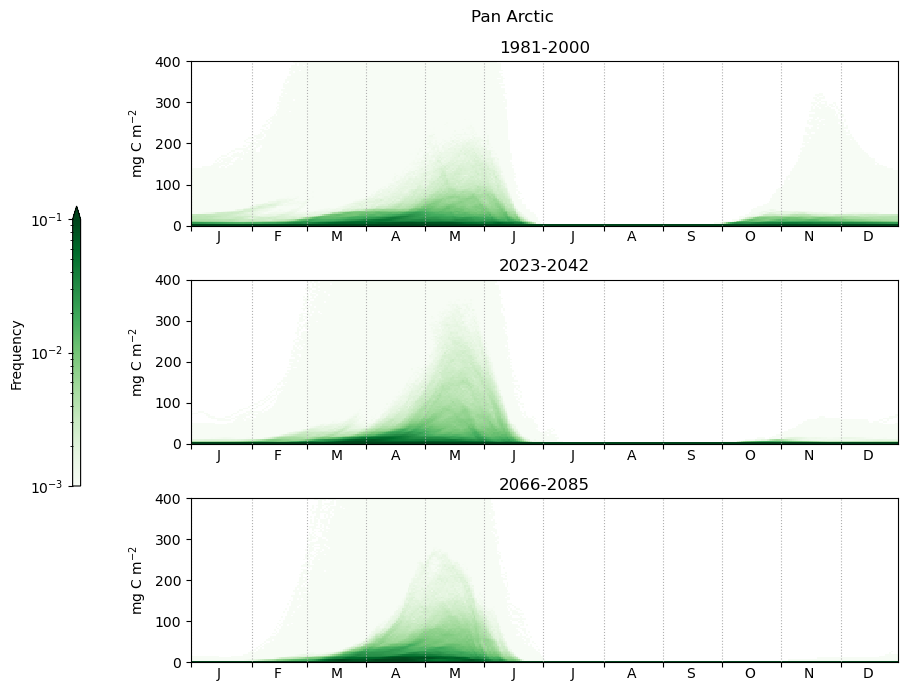

In [255]:
vmin,vmax=1e-3,0.1
fig,ax=IAhist('Pan Arctic', vmin=vmin,vmax=vmax, logscale=True)
plt.tight_layout()

cbar_ax = fig.add_axes([-0.05, 0.3, 0.01, 0.4])  
# smap = plt.cm.ScalarMappable(cmap='Greens', norm = plt.Normalize(0,vmax))
smap = plt.cm.ScalarMappable(cmap='Greens', norm = colors.LogNorm(vmin=vmin, vmax=vmax))

cl=fig.colorbar(smap,cax=cbar_ax,extend='max')
cl.set_label('Frequency')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
# cl.ax.locator_params(nbins=4)

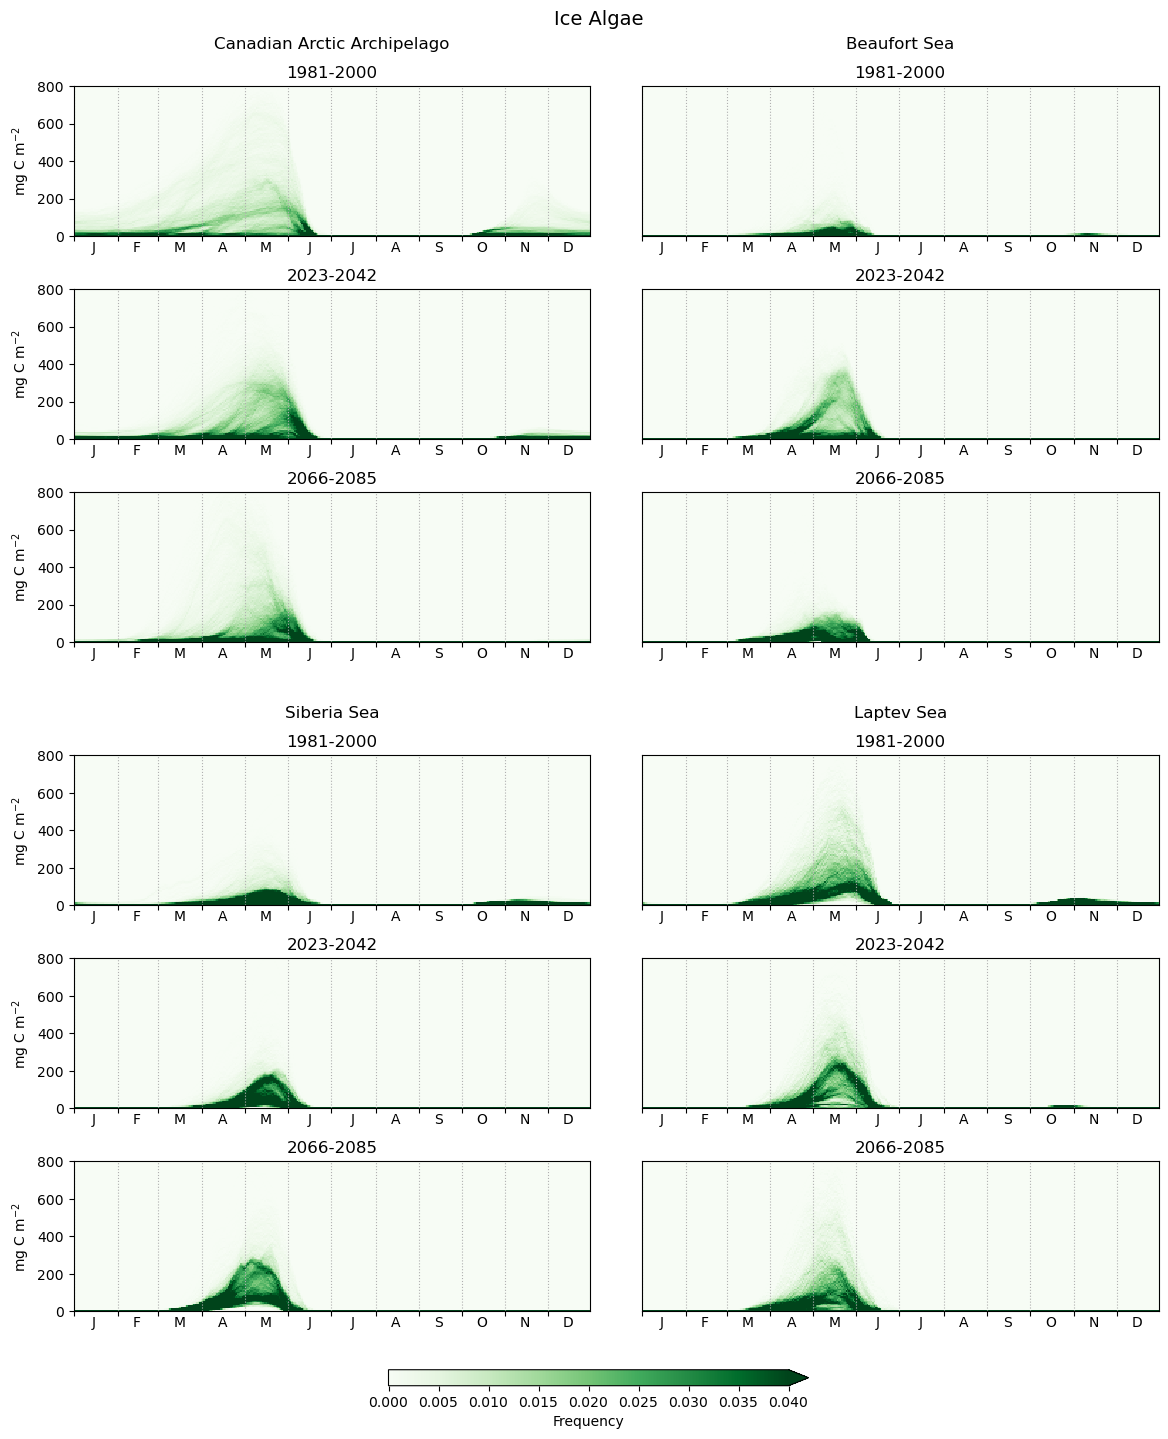

In [256]:
vmax=0.04

gs = gridspec.GridSpec(9, 2, width_ratios=[1, 1],height_ratios=[0.05,1,1,1,0.05,1,1,1,0.25],wspace=0.1, hspace=0.5, top=0.97) 
fig=plt.figure(figsize=(14,16))
plt.suptitle('Ice Algae',fontsize=14)
plt.tight_layout()

for ir,rgn in enumerate(regs):
    ax=plt.subplot(gs[int(ir/2)*4, (ir%2)])
    ax.text(0.5,-2, rgn, horizontalalignment='center', fontsize=12)
    ax.set_axis_off()
    
    ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*4+1,int(ir/2)*4+4)]
    IAhist(rgn, fig, ax=ax, vmax=vmax, leftSpines=1-(ir%2))


cbar_ax = fig.add_axes([1/2-0.15, 0.12, 0.3, 0.01])  
smap = plt.cm.ScalarMappable(cmap='Greens', norm = plt.Normalize(0,vmax))
cl=fig.colorbar(smap,cax=cbar_ax,extend='max', orientation='horizontal')
cl.set_label('Frequency')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
# cl.ax.locator_params(nbins=4)

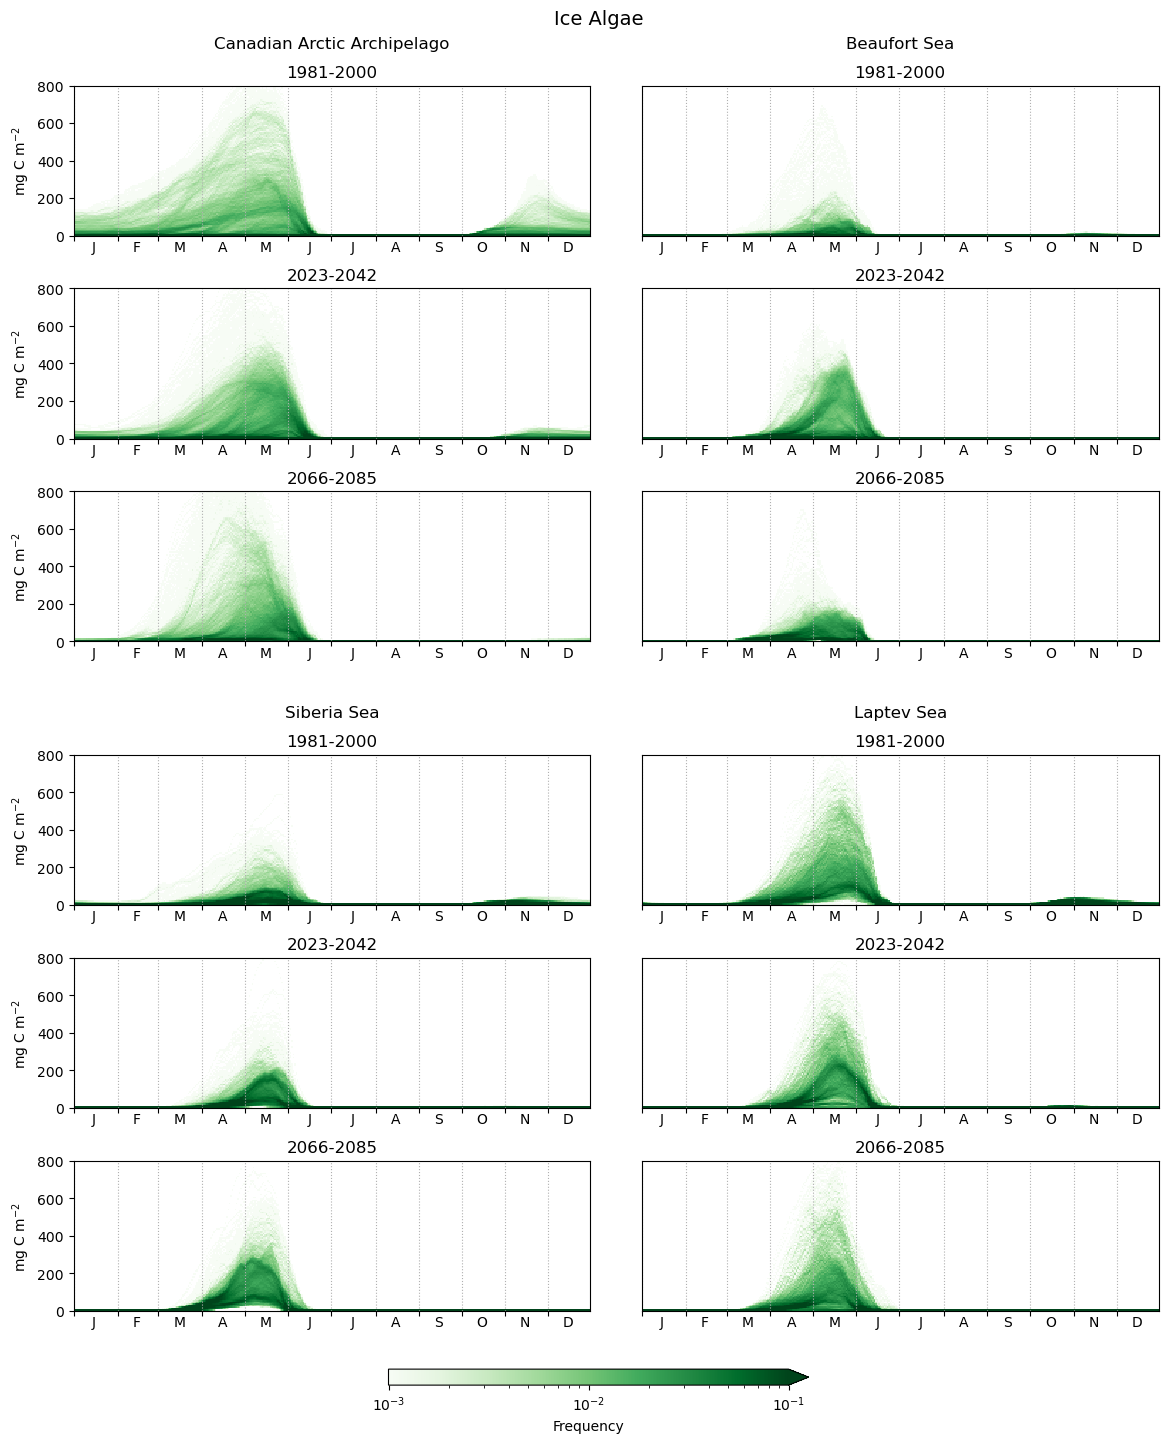

In [80]:
vmin,vmax=1e-3,0.1

gs = gridspec.GridSpec(9, 2, width_ratios=[1, 1],height_ratios=[0.05,1,1,1,0.05,1,1,1,0.25],wspace=0.1, hspace=0.5, top=0.97) 
fig=plt.figure(figsize=(14,16))
plt.suptitle('Ice Algae',fontsize=14)
plt.tight_layout()

for ir,rgn in enumerate(regs):
    ax=plt.subplot(gs[int(ir/2)*4, (ir%2)])
    ax.text(0.5,-2, rgn, horizontalalignment='center', fontsize=12)
    ax.set_axis_off()
    
    ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*4+1,int(ir/2)*4+4)]
    IAhist(rgn, fig, ax=ax, leftSpines=1-(ir%2),vmin=vmin,vmax=vmax, logscale=True)


cbar_ax = fig.add_axes([1/2-0.15, 0.12, 0.3, 0.01])  
smap = plt.cm.ScalarMappable(cmap='Greens', norm = colors.LogNorm(vmin=vmin, vmax=vmax))

cl=fig.colorbar(smap,cax=cbar_ax,extend='max', orientation='horizontal')
cl.set_label('Frequency')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
# cl.ax.locator_params(nbins=4)

### IA + IA dates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


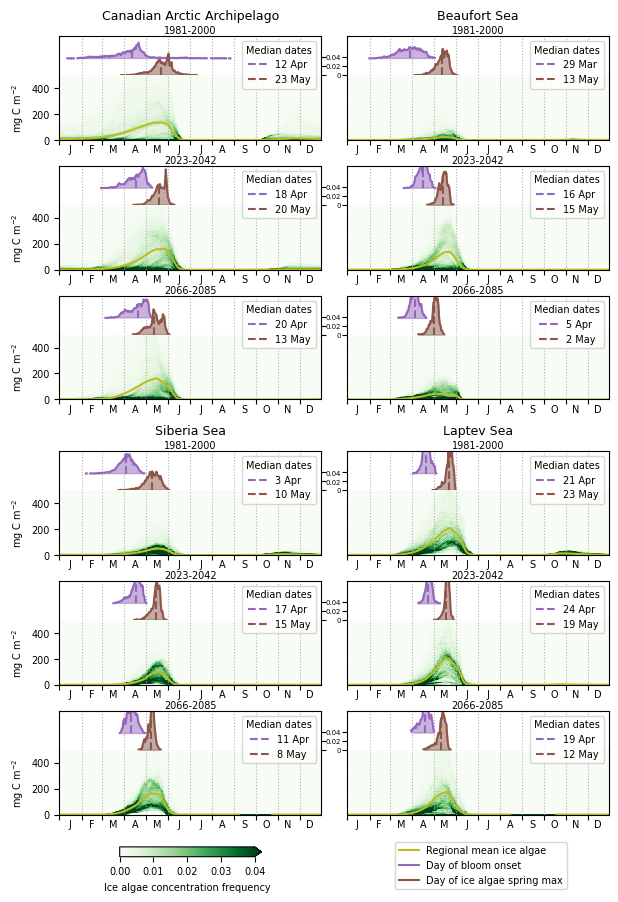

In [23]:
vmax=0.04

gs = gridspec.GridSpec(21, 2, width_ratios=[1, 1],
                       height_ratios=[0.4,
                                      0.6,1,0.4,0.6,1,0.4,0.6,1,0.4,
                                      0.4,
                                      0.6,1,0.4,0.6,1,0.4,0.6,1,0.4,
                                      0.25],
                       wspace=0.1, hspace=0, top=0.97) 
# fig=plt.figure(figsize=(14,16))
# plt.rcParams.update({'font.size': 10})

fig=plt.figure(figsize=(18/2.54,25/2.54))
plt.rcParams.update({'font.size': 7})

plt.tight_layout()

for ir,rgn in enumerate(regs):
    ax=plt.subplot(gs[int(ir/2)*10, (ir%2)])
    ax.text(0.5,0.65, rgn, horizontalalignment='center', fontsize=9)
    ax.set_axis_off()
    
    ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*10+2,int(ir/2)*10+9,3)]
    IAhist(rgn, fig, ax=ax, vmax=vmax, leftSpines=1-(ir%2))
    for a in ax: a.spines[['top']].set_visible(False)

    # regional mean IA
    for ip, per in enumerate(periods):
        ax[ip].plot(days, clim[per+rgn+'regMeanIA']*12, 'tab:olive')
    
    # dates hist
    ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*10+1,int(ir/2)*10+8,3)]
    freqMax=0.05;yticks=[0,0.02,0.04]
    for ip, per in enumerate(periods):
        ax[ip].set_title(per,y=1.,x=0.5,pad=2, fontsize=7)
        ax[ip].set_xlim(days[0],days[-1])
        ax[ip].set_ylim(0,1.75*freqMax) 
        ax[ip].set_xticks(fstdayofmonth, []);ax[ip].tick_params(axis='x', length=0)
        ax[ip].grid(axis='x',ls=':')
        ax[ip].spines[['bottom']].set_visible(False)
        if (ir%2): ax[ip].set_yticks(yticks,yticks,fontsize=5) 
        else: ax[ip].yaxis.tick_right(); ax[ip].set_yticks(yticks,[]) 
        ax[ip].tick_params(axis='y', which='major', pad=1)  # move the tick labels
        
        pltdayHist(hist[rgn+per+'doyIAstd'], climdiag[per]['doyIAstd'].where(rgnMsk[rgn]), stdc,'IA STD', fig,ax[ip], fill=True, pad=0.75*freqMax)
        pltdayHist(hist[rgn+per+'doyIApeak'], climdiag[per]['doyIApeak'].where(rgnMsk[rgn]), mxc,'IA spring max', fig,ax[ip], fill=True, pad=0)
        ax[ip].legend(loc='upper right',title="Median dates")
        


cbar_ax = fig.add_axes([1/4-0.04, 0.11, 0.2, 0.01])  
smap = plt.cm.ScalarMappable(cmap='Greens', norm = plt.Normalize(0,vmax))
cl=fig.colorbar(smap,cax=cbar_ax,extend='max', orientation='horizontal')
cl.set_label('Ice algae concentration frequency')
cbar_ax.set_xticks([0,0.01,0.02,0.03,0.04]);

ax= fig.add_axes([3/4-0.18, 0.12, 0.3, 0.01])      
ax.set_axis_off()
ax.legend(loc='upper center', ncol=1, handles=[
    Line2D([], [], color='tab:olive', label='Regional mean ice algae'),
    Line2D([], [], color=stdc, label='Day of bloom onset'),
    Line2D([], [], color=mxc, label='Day of ice algae spring max'), 
                    ]);

# plt.savefig('figs/IAphenology23/IAseasoncycle+dates-regions.png',bbox_inches='tight',dpi=150)
# plt.savefig('figs/IAphenology23/IAseasoncycle+dates-regions.eps',bbox_inches='tight',dpi=300)

In [80]:
def pltIAregMeanHistKeyDates(regs, labelpos=(0.01,0.65)):

    vmax=0.04
    ltr=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

    gs = gridspec.GridSpec(11, 2, width_ratios=[1, 1],
                           height_ratios=[0.4,
                                          0.6,1,0.6,0.6,1,0.6,0.6,1,0.4,
                                          # 0.4,
                                          # 0.6,1,0.4,0.6,1,0.4,0.6,1,0.4,
                                          0.25],
                           wspace=0.1, hspace=0, top=0.97) 
    # fig=plt.figure(figsize=(14,16))
    # plt.rcParams.update({'font.size': 10})

    fig=plt.figure(figsize=(18/2.54,13/2.54))
    plt.rcParams.update({'font.size': 8})

    plt.tight_layout()

    for ir,rgn in enumerate(regs):
        ax=plt.subplot(gs[int(ir/2)*10, (ir%2)])
        ax.text(0.5,0.65, rgn, horizontalalignment='center', fontsize=10)
        ax.set_axis_off()

        ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*10+2,int(ir/2)*10+9,3)]
        IAhist(rgn, fig, ax=ax, vmax=vmax, leftSpines=1-(ir%2))
        for a in ax: a.spines[['top']].set_visible(False)

        # regional mean IA
        for ip, per in enumerate(periods):
            ax[ip].plot(days, clim[per+rgn+'regMeanIA']*12, 'tab:olive')

        # dates hist
        ax=[plt.subplot(gs[i,(ir%2)]) for i in range(int(ir/2)*10+1,int(ir/2)*10+8,3)]
        freqMax=0.05;yticks=[0,0.02,0.04]
        for ip, per in enumerate(periods):
            ax[ip].set_title(per,y=1.,x=0.5,pad=2, fontsize=8)
            ax[ip].set_xlim(days[0],days[-1])
            ax[ip].set_ylim(0,1.75*freqMax) 
            ax[ip].set_xticks(fstdayofmonth, []);ax[ip].tick_params(axis='x', length=0)
            ax[ip].grid(axis='x',ls=':')
            ax[ip].spines[['bottom']].set_visible(False)
            if (ir%2): ax[ip].set_yticks(yticks,yticks,fontsize=5) 
            else: ax[ip].yaxis.tick_right(); ax[ip].set_yticks(yticks,[]) 
            ax[ip].tick_params(axis='y', which='major', pad=1)  # move the tick labels

            pltdayHist(hist[rgn+per+'doyIAstd'], climdiag[per]['doyIAstd'].where(rgnMsk[rgn]), stdc,'IA STD', fig,ax[ip], fill=True, pad=0.75*freqMax)
            pltdayHist(hist[rgn+per+'doyIApeak'], climdiag[per]['doyIApeak'].where(rgnMsk[rgn]), mxc,'IA spring max', fig,ax[ip], fill=True, pad=0)
            ax[ip].legend(loc='upper right',title="Median dates")
            ax[ip].text(*labelpos,f'({ltr[ip+3*ir]})',transform=ax[ip].transAxes, fontsize=10)


    cbar_ax = fig.add_axes([1/4-0.04, 0.11, 0.2, 0.02])  
    smap = plt.cm.ScalarMappable(cmap='Greens', norm = plt.Normalize(0,vmax))
    cl=fig.colorbar(smap,cax=cbar_ax,extend='max', orientation='horizontal')
    cl.set_label('Ice algae concentration frequency')
    cbar_ax.set_xticks([0,0.01,0.02,0.03,0.04]);

    ax= fig.add_axes([3/4-0.18, 0.12, 0.3, 0.01])      
    ax.set_axis_off()
    ax.legend(loc='upper center', ncol=1, handles=[
        Line2D([], [], color='tab:olive', label='Mean ice algae concentration'),
        Line2D([], [], color=stdc, label='Day of bloom onset'),
        Line2D([], [], color=mxc, label='Day of ice algae spring max'), 
                        ]);

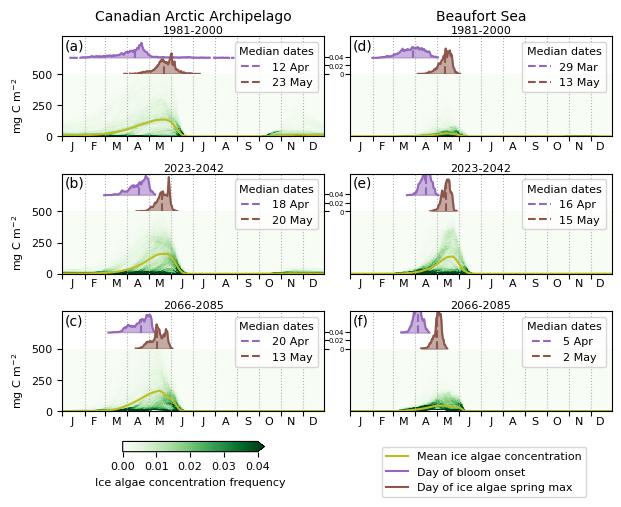

In [81]:
pltIAregMeanHistKeyDates(regs[:2])
plt.savefig('../figs/IAphenology23/IAseasoncycle+dates-CAA+Beaufort.png',bbox_inches='tight',dpi=300)

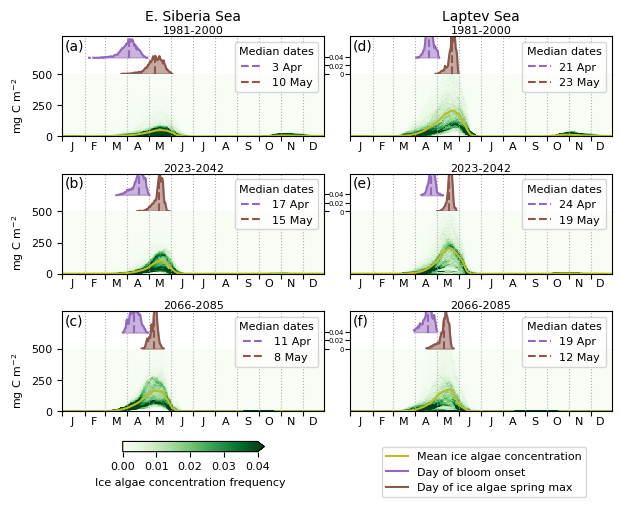

In [82]:
pltIAregMeanHistKeyDates(regs[2:])
plt.savefig('../figs/IAphenology23/IAseasoncycle+dates-SiberaLaptev.png',bbox_inches='tight',dpi=300)